In [17]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/195733
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
weather_fg = fs.get_feature_group(name="weather", version=3)
query = weather_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="weather",
                                             version=3,
                                             description="Read from Weather",
                                             query=query)

In [4]:
# set up dates
train_start = "1996-02-01 22:00:00"
train_end = "2020-02-01 22:00:00"
test_start = "2020-02-01 22:00:00"
test_end = "2024-01-03 08:00:00"

# create a train-test split dataset
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end
)

Finished: Reading data from Hopsworks, using ArrowFlight (4.88s) 


In [5]:
print(X_train.columns)
print(X_test.columns)
# print(y_train.info())
# print(y_test.info())
# X_train = X_train.reset_index()
# X_test = X_test.reset_index()
X_train = X_train.set_index("date_time")
X_test = X_test.set_index("date_time")
X_train = X_train.asfreq('h')
X_test = X_test.asfreq('h')
X_train = X_train.drop(columns=["id"])
X_test = X_test.drop(columns=["id"])
print(X_train.columns)
print(X_test.columns)

Index(['date_time', 'lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')
Index(['date_time', 'lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')
Index(['lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur'],
      dtype='object')
Index(['lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur'],
      dtype='object')


In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210384 entries, 1996-02-01 22:00:00+00:00 to 2020-02-01 21:00:00+00:00
Freq: H
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   lufttemperatur             210384 non-null  float64
 1   vindriktning               210384 non-null  float64
 2   vindhastighet              210384 non-null  float64
 3   relativ_luftfuktighet      210384 non-null  float64
 4   nederbrdsmngd              210384 non-null  float64
 5   sikt                       210384 non-null  float64
 6   byvind                     210384 non-null  float64
 7   max_av_medelvindhastighet  210384 non-null  float64
 8   daggpunktstemperatur       210384 non-null  float64
dtypes: float64(9)
memory usage: 16.1 MB


In [7]:
X_train.head()

,lufttemperatur,vindriktning,vindhastighet,relativ_luftfuktighet,nederbrdsmngd,sikt,byvind,max_av_medelvindhastighet,daggpunktstemperatur
date_time,,,,,,,,,
1996-02-01 22:00:00+00:00,-7.7,252.0,1.1,98.0,0.0,31066.052812,1.8,2.7,-8.0
1996-02-01 23:00:00+00:00,-6.7,261.0,1.4,96.0,0.0,31066.225879,2.4,2.1,-7.3
1996-02-02 00:00:00+00:00,-6.2,252.0,1.1,95.0,0.0,31066.398947,1.9,1.8,-6.9
1996-02-02 01:00:00+00:00,-5.6,312.0,1.2,93.0,0.0,31066.572015,2.1,1.5,-6.6
1996-02-02 02:00:00+00:00,-5.5,289.0,0.9,94.0,0.0,31066.745083,2.3,1.4,-6.4


In [37]:
#X_train['combine'] = list(X_train.values)
window_size = 12

training_window = sliding_window_view(X_train.values, (window_size, 1))
training_data = training_window[:-1]
training_target = training_window[1:, :, -1]
test_window = sliding_window_view(X_test.values, (window_size, 1))
test_data = test_window[:-1]
test_target = test_window[1:, :, -1]

training_data = training_data.reshape((training_data.shape[0], -1))
training_target = training_target.reshape((training_target.shape[0], -1))
test_data = test_data.reshape((test_data.shape[0], -1))
test_target = test_target.reshape((test_target.shape[0], -1))

In [38]:
print(training_data.shape)
print(training_data[1])

(210372, 108)
[-6.70000000e+00 -6.20000000e+00 -5.60000000e+00 -5.50000000e+00
 -5.40000000e+00 -5.30000000e+00 -5.30000000e+00 -5.60000000e+00
 -5.70000000e+00 -5.50000000e+00 -4.90000000e+00 -5.20000000e+00
  2.61000000e+02  2.52000000e+02  3.12000000e+02  2.89000000e+02
  3.24500000e+02  3.60000000e+02  3.33000000e+02  0.00000000e+00
  2.39000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.40000000e+00  1.10000000e+00  1.20000000e+00  9.00000000e-01
  1.10000000e+00  1.30000000e+00  2.20000000e+00  0.00000000e+00
  8.00000000e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.60000000e+01  9.50000000e+01  9.30000000e+01  9.40000000e+01
  9.40000000e+01  9.40000000e+01  9.40000000e+01  9.60000000e+01
  9.70000000e+01  9.70000000e+01  9.50000000e+01  9.40000000e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.1066225

In [39]:
print(training_target.shape)
print(training_target[0])

(210372, 9)
[-5.20000000e+00  0.00000000e+00  0.00000000e+00  9.40000000e+01
  0.00000000e+00  3.10681296e+04  1.00000000e+00  6.00000000e-01
 -6.00000000e+00]


In [40]:
#forecaster = ForecasterAutoreg(
#                 regressor = RandomForestRegressor(random_state=123),
#                 lags      = 6,
#             )

reg = RandomForestRegressor(random_state=123)

#forecaster.fit(y=X_train['combine'])
#forecaster

reg.fit(training_data, training_target)

In [16]:
#predictions = forecaster.predict(steps=4, exog=X_test.drop(columns=["lufttemperatur"]))
predictions = reg.predict(test_data)
error_mse = mean_squared_error(
                 y_true = test_target,
                 y_pred = predictions
             )
print(f"[Total] Test error (MSE): {error_mse}")
error_mse = mean_squared_error(
                 y_true = test_target[:, 0],
                 y_pred = predictions[:, 0]
             )
print(f"[Temp] Test error (MSE): {error_mse}")

print(predictions[:5])
print(test_target[:5])
# error_mse = 0
# y_true = X_test["lufttemperatur"]
# for i in range(len(y_true)-4):
#     for s in range(4):
#         error_mse += (y_true[i+s] - predictions[i][s])**2 / (len(y_true) * 4)


[Total] Test error (MSE): 11091063.450961042
[Temp] Test error (MSE): 2.896907393741813
[[6.79550000e+00 2.22135000e+02 4.19700000e+00 8.54362757e+01
  2.50000000e-02 2.00481700e+04 7.88850000e+00 5.07450000e+00
  4.42578052e+00]
 [6.37600000e+00 2.16320000e+02 3.80300000e+00 8.96927984e+01
  2.40000000e-02 1.80702755e+04 7.46700000e+00 4.99500000e+00
  4.72545405e+00]
 [6.87900000e+00 2.29280000e+02 4.46000000e+00 8.45400000e+01
  6.00000000e-03 3.73770000e+04 8.65600000e+00 5.64250000e+00
  4.44000000e+00]
 [6.14400000e+00 2.38001667e+02 4.54716667e+00 8.67030051e+01
  4.00000000e-03 2.55568717e+04 8.54333221e+00 5.92466667e+00
  4.02942524e+00]
 [6.67600000e+00 2.35987424e+02 4.44300000e+00 9.30800000e+01
  3.73000000e-01 1.98755400e+04 8.45700000e+00 5.86718182e+00
  5.62700000e+00]]
[[5.9000e+00 2.2200e+02 4.3000e+00 9.1000e+01 0.0000e+00 1.8211e+04
  7.2000e+00 5.0000e+00 4.6000e+00]
 [6.3000e+00 2.2600e+02 5.4000e+00 8.7000e+01 0.0000e+00 3.9146e+04
  7.8000e+00 5.4000e+00 4.400

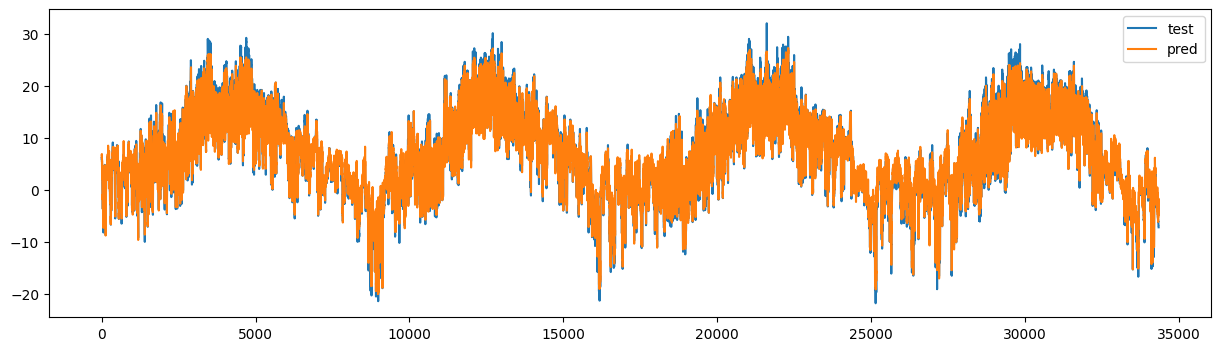

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))
#training_target[:, 0].plot(ax=ax, label='train')
ax.plot(test_target[:, 0], label='test')
ax.plot(predictions[:, 0], label='pred')
ax.legend();

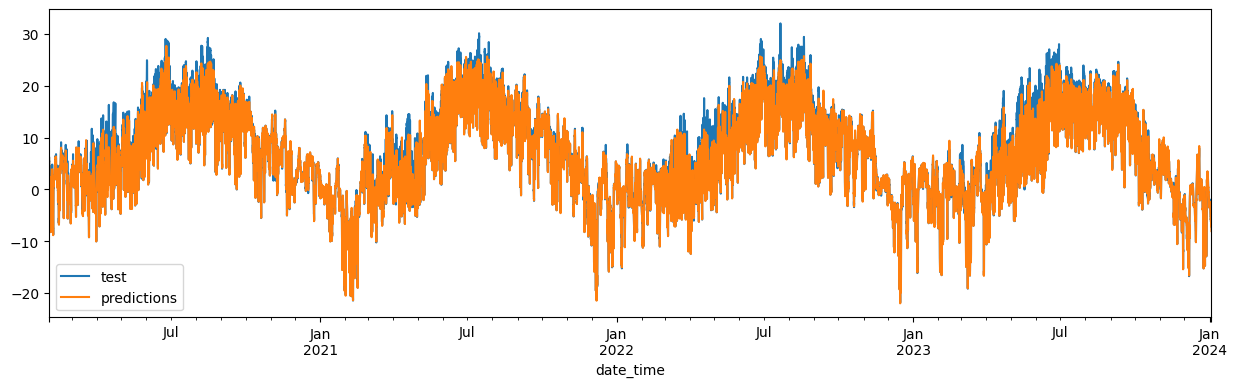

In [33]:
fig, ax = plt.subplots(figsize=(15, 4))
X_test['lufttemperatur'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
mr = project.get_model_registry()
model = reg

model_dir="temp_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/temp_model.pkl")
#fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(training_data[0])
output_schema = Schema(training_target[0])
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
temp_model = mr.python.create_model(
    name="temp_model", 
    metrics={"mse" : error_mse},
    model_schema=model_schema,
    description="Temperature Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
temp_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████| 6/6 [00:15<00:00,  2.52s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/195733/models/wine_model/2


Model(name: 'wine_model', version: 2)